# Sanity check: looking for biases and loss of information in the various CEH models
Context:<br>
Fitting PSBs properly seems to require better accounting for their metallicity than just assuming a uniform and constant metallicity free parameter (see the 8 tests). Informed by Yirui's simulation and closed box models, we came up with these two advanced metallicity evolution models:
1. psb_two_step: decoupled individually free metallicity parameters before and after burst. Transition set at SFH comp's `burstage` parameter
2. psb_linear_step: introducing an extra slope free parameter to the psb_two_step model that controls the pre-burst metallicity, defined as slope = d(Z*/Zsun)/d(lookback time in Gyr), so an increasing metallicity galaxy will have a negative slope value. A `metallicity_zero` replaces the `metallicity_old` parameter, which is defined as the metallicity at lookback time = 0 for the sloped bit.

However, when we run recovery tests on these increasingly more complicated models, we discover that the accuracy of the recovered SFH deteriates, even when there is no possible model-data mismatches. This is especially severe in intermediate-age populations, where SFR right before burst is very overestimated. <br>

In PSBonly_P6, we are seeing a significant portion of galaxies jumping from sub-solar Z to >2x solar Z after the burst. Crossing checking with gas-phase metallicity values provided by Nick showed no agreements between that and P6's metallicity values. We suspect there might be issues with the Bagpipes+2step metallicity model that introduces biases towards this jumping. <br>

To test all this, I set up this series of recovery tests, to see at which stage things start to fall apart.

In [2]:
import bagpipes as pipes
# setting bagpipes R_spec to as high as possible for perfect generation of models
pipes.config.R_spec = 4340
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

import sys
sys.path.append('../../..')
from code_bits.fitting import *
from code_bits.add_psbtwin import *
from code_bits.add_ceh_funcs import *

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


In [3]:
# load in true SFH
model_ages_original, model_sfh = load_model_sfh('../../../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')

In [4]:
spectrum = np.loadtxt(fname='../../../Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_'+
                      "2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test"+".csv", 
                      delimiter=',', skiprows=1)
obs_wavs = spectrum[:,0]

### To avoid the severe bias to the `age` parameter in psb SFH comps (means the lookback time of beginning of star formation), I am shifting and compressing Yirui's model truth SFH closer to the observation time, making beginning of star formation to be closer to cosmic noon at z~2-3.

10.350524938318015 Gyr


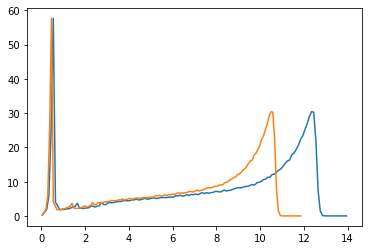

In [5]:
squishing_factor = 0.85
model_ages = model_ages_original*squishing_factor
plt.plot(model_ages_original, model_sfh)
plt.plot(model_ages, model_sfh)
print(cosmo.age(0.04) - cosmo.age(2.5))

[1.06817341e+01 3.23549458e+00 4.67499997e-01 2.29522818e+02
 5.34899465e+02 9.24162911e-02 1.09328153e+01]
[1.05922853e+01 1.70248944e+00 7.52360609e+04 4.67499913e-01
 2.26739114e+02 5.86080092e+02 8.97794261e-02 1.09355331e+01]


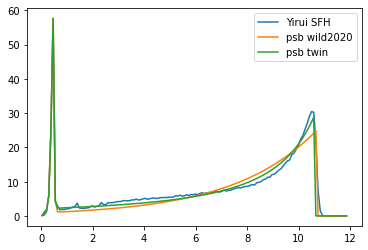

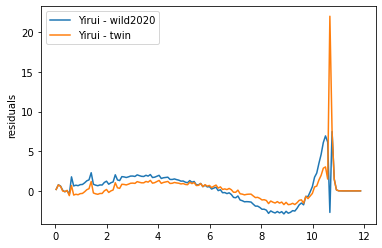

In [6]:
import scipy
# using scipy curve fit to get a fit to the true SFH
popt_wild2020,pcov = scipy.optimize.curve_fit(psb_wild2020, model_ages, model_sfh, 
                                     bounds=([10.5,0.5,0,100,100,0,10],[13,10,2,1000,1000,1,12]))
# best fits
print(popt_wild2020)

# using scipy curve fit to get a fit to the true SFH
popt_twin,pcov = scipy.optimize.curve_fit(psb_twin_, model_ages, model_sfh, 
                                     bounds=([10,0.01,1000,0,10,10,0,10],[13,1000,100000,2,1000,1000,1,12]))
# best fits
print(popt_twin)

predict_sfh_wild2020 = psb_wild2020(model_ages, *popt_wild2020)
predict_sfh_twin = psb_twin_(model_ages, *popt_twin)
plt.plot(model_ages, model_sfh, label='Yirui SFH')
plt.plot(model_ages, predict_sfh_wild2020, label='psb wild2020')
plt.plot(model_ages, predict_sfh_twin, label='psb twin')
plt.legend()
plt.show()
plt.plot(model_ages, model_sfh-predict_sfh_wild2020, label='Yirui - wild2020')
plt.plot(model_ages, model_sfh-predict_sfh_twin, label='Yirui - twin')
plt.ylabel('residuals')
plt.legend()
plt.show()

### Now set up a table of meta settings for all runs

In [8]:
"""
cols = [m_SFH, m_CEH, m_zmet_old, m_zmet_burst, 
        m_zmet_slope, f_SFH, f_CEH, f_CEH_fixed, 
        f_nlive]
"""
fits_list = []
# delta
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'delta',
                 'm_zmet_old':1.0, 'f_SFH':'psb_wild2020',
                 'f_CEH':'delta', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'delta',
                 'm_zmet_old':2.0, 'f_SFH':'psb_wild2020',
                 'f_CEH':'delta', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'yirui', 'm_CEH':'delta',
                 'm_zmet_old':1.0, 'f_SFH':'psb_wild2020',
                 'f_CEH':'delta', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'psb_twin', 'm_CEH':'delta',
                 'm_zmet_old':1.0, 'f_SFH':'psb_twin',
                 'f_CEH':'2step', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'psb_twin', 'm_CEH':'delta',
                 'm_zmet_old':2.0, 'f_SFH':'psb_twin',
                 'f_CEH':'2step', 'f_CEH_fixed':False,
                 'f_nlive':400})
# 2step
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'2step',
                 'm_zmet_old':1.0, 'm_zmet_burst':2.0,
                 'f_SFH':'psb_wild2020', 'f_CEH':'2step', 
                 'f_CEH_fixed':True, 'f_nlive':400})
fits_list.append({'m_SFH':'yirui', 'm_CEH':'2step',
                 'm_zmet_old':1.0, 'm_zmet_burst':2.0,
                 'f_SFH':'psb_wild2020', 'f_CEH':'2step', 
                 'f_CEH_fixed':True, 'f_nlive':400})
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'2step',
                 'm_zmet_old':1.0, 'm_zmet_burst':2.0,
                 'f_SFH':'psb_wild2020', 'f_CEH':'2step', 
                 'f_CEH_fixed':False, 'f_nlive':400})
fits_list.append({'m_SFH':'yirui', 'm_CEH':'2step',
                 'm_zmet_old':1.0, 'm_zmet_burst':2.0,
                 'f_SFH':'psb_twin', 'f_CEH':'2step', 
                 'f_CEH_fixed':False, 'f_nlive':400})
fits_list.append({'m_SFH':'yirui', 'm_CEH':'2step',
                 'm_zmet_old':1.0, 'm_zmet_burst':2.0,
                 'f_SFH':'psb_twin', 'f_CEH':'2step', 
                 'f_CEH_fixed':False, 'f_nlive':1000})
# slope+2step
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'slope+2step',
                 'm_zmet_old':'auto', 'm_zmet_burst':2.0,
                 'm_zmet_slope':-0.1, 'f_SFH':'psb_wild2020',
                 'f_CEH':'slope+2step', 'f_CEH_fixed':True,
                 'f_nlive':400})
fits_list.append({'m_SFH':'psb_twin', 'm_CEH':'slope+2step',
                 'm_zmet_old':'auto', 'm_zmet_burst':2.0,
                 'm_zmet_slope':-0.1, 'f_SFH':'psb_twin',
                 'f_CEH':'slope+2step', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'psb_twin', 'm_CEH':'slope+2step',
                 'm_zmet_old':'auto', 'm_zmet_burst':2.0,
                 'm_zmet_slope':-0.1, 'f_SFH':'psb_twin',
                 'f_CEH':'slope+2step', 'f_CEH_fixed':False,
                 'f_nlive':1000})

fit_table = pd.DataFrame(fits_list)[
    ['m_SFH', 'm_CEH', 'm_zmet_old', 'm_zmet_burst', 
     'm_zmet_slope', 'f_SFH', 'f_CEH', 'f_CEH_fixed', 
     'f_nlive']
]
fit_table

m_SFH        m_CEH m_zmet_old  m_zmet_burst  m_zmet_slope  \
0   psb_wild2020        delta          1           NaN           NaN   
1   psb_wild2020        delta          2           NaN           NaN   
2          yirui        delta          1           NaN           NaN   
3       psb_twin        delta          1           NaN           NaN   
4       psb_twin        delta          2           NaN           NaN   
5   psb_wild2020        2step          1           2.0           NaN   
6          yirui        2step          1           2.0           NaN   
7   psb_wild2020        2step          1           2.0           NaN   
8          yirui        2step          1           2.0           NaN   
9          yirui        2step          1           2.0           NaN   
10  psb_wild2020  slope+2step       auto           2.0          -0.1   
11      psb_twin  slope+2step       auto           2.0          -0.1   
12      psb_twin  slope+2step       auto           2.0          -0.1   

           f_SFH        f_CEH  f_CEH_fixed  f_nlive  
0   psb_wild2020        delta        False      400  
1   psb_wild2020        delta        False      400  
2   psb_wild2020        delta        False      400  
3       psb_twin        2step        False      400  
4       psb_twin        2step        False      400  
5   psb_wild2020        2step         True      400  
6   psb_wild2020        2step         True      400  
7   psb_wild2020        2step        False      400  
8       psb_twin        2step        False      400  
9       psb_twin        2step        False     1000  
10  psb_wild2020  slope+2step         True      400  
11      psb_twin  slope+2step        False      400  
12      psb_twin  slope+2step        False     1000

In [9]:
def genIDs(fit_settings):
    # galID = {m_SFH}_{m_CEH}{delta's metallicity}
    if fit_settings['m_SFH'] == 'yirui':
        m_SFH = fit_settings['m_SFH']
    elif fit_settings['m_SFH'] == 'psb_wild2020':
        m_SFH = 'psb2'
    elif fit_settings['m_SFH'] == 'psb_twin':
        m_SFH = 'psbtwin'
        
    if fit_settings['m_CEH'] == 'delta':
        m_CEH = 'uniform'+str(int(fit_settings['m_zmet_old']))+'Zsun'
    else: m_CEH = fit_settings['m_CEH']
    
    galID = f'{m_SFH}_{m_CEH}'
    
    # runID = {f_SFH}_{f_CEH}_{fixed or not}_{nlive}
    if fit_settings['f_SFH'] == 'psb_wild2020':
        f_SFH = 'psb2'
    elif fit_settings['f_SFH'] == 'psb_twin':
        f_SFH = 'psbtwin'
    
    f_CEH = fit_settings['f_CEH']
    
    if fit_settings['f_CEH_fixed']:
        f_CEH_fixed = '_fixed'
    else: f_CEH_fixed = ''
    
    runID = f"{f_SFH}_{f_CEH}{f_CEH_fixed}_nlive{str(fit_settings['f_nlive'])}_bin_by_1_4340_Rspec"
    
    return galID, runID

fit_table['galID'] = ''
fit_table['runID'] = ''
for i,row in fit_table.iterrows():
    galID, runID = genIDs(row)
    print(galID, runID)
    fit_table.loc[i,'galID'] = galID
    fit_table.loc[i,'runID'] = runID
# old_fit = True means that it is recycling a previously-done fit for another test that also fit the
# requirements, but used the non-altered version of Yirui's true SFH. This means the results will not be
# directly comparable but conclusions should still be possible to be drawn
fit_table['old_fit'] = [False, False, False, True, True, False, False, 
                        False, False, False, False, True, True]
                        
fit_table

psb2_uniform1Zsun psb2_delta_nlive400_bin_by_1_4340_Rspec
psb2_uniform2Zsun psb2_delta_nlive400_bin_by_1_4340_Rspec
yirui_uniform1Zsun psb2_delta_nlive400_bin_by_1_4340_Rspec
psbtwin_uniform1Zsun psbtwin_2step_nlive400_bin_by_1_4340_Rspec
psbtwin_uniform2Zsun psbtwin_2step_nlive400_bin_by_1_4340_Rspec
psb2_2step psb2_2step_fixed_nlive400_bin_by_1_4340_Rspec
yirui_2step psb2_2step_fixed_nlive400_bin_by_1_4340_Rspec
psb2_2step psb2_2step_nlive400_bin_by_1_4340_Rspec
yirui_2step psbtwin_2step_nlive400_bin_by_1_4340_Rspec
yirui_2step psbtwin_2step_nlive1000_bin_by_1_4340_Rspec
psb2_slope+2step psb2_slope+2step_fixed_nlive400_bin_by_1_4340_Rspec
psbtwin_slope+2step psbtwin_slope+2step_nlive400_bin_by_1_4340_Rspec
psbtwin_slope+2step psbtwin_slope+2step_nlive1000_bin_by_1_4340_Rspec


m_SFH        m_CEH m_zmet_old  m_zmet_burst  m_zmet_slope  \
0   psb_wild2020        delta          1           NaN           NaN   
1   psb_wild2020        delta          2           NaN           NaN   
2          yirui        delta          1           NaN           NaN   
3       psb_twin        delta          1           NaN           NaN   
4       psb_twin        delta          2           NaN           NaN   
5   psb_wild2020        2step          1           2.0           NaN   
6          yirui        2step          1           2.0           NaN   
7   psb_wild2020        2step          1           2.0           NaN   
8          yirui        2step          1           2.0           NaN   
9          yirui        2step          1           2.0           NaN   
10  psb_wild2020  slope+2step       auto           2.0          -0.1   
11      psb_twin  slope+2step       auto           2.0          -0.1   
12      psb_twin  slope+2step       auto           2.0          -0.1   

           f_SFH        f_CEH  f_CEH_fixed  f_nlive                 galID  \
0   psb_wild2020        delta        False      400     psb2_uniform1Zsun   
1   psb_wild2020        delta        False      400     psb2_uniform2Zsun   
2   psb_wild2020        delta        False      400    yirui_uniform1Zsun   
3       psb_twin        2step        False      400  psbtwin_uniform1Zsun   
4       psb_twin        2step        False      400  psbtwin_uniform2Zsun   
5   psb_wild2020        2step         True      400            psb2_2step   
6   psb_wild2020        2step         True      400           yirui_2step   
7   psb_wild2020        2step        False      400            psb2_2step   
8       psb_twin        2step        False      400           yirui_2step   
9       psb_twin        2step        False     1000           yirui_2step   
10  psb_wild2020  slope+2step         True      400      psb2_slope+2step   
11      psb_twin  slope+2step        False      400   psbtwin_slope+2step   
12      psb_twin  slope+2step        False     1000   psbtwin_slope+2step   

                                                runID  old_fit  
0             psb2_delta_nlive400_bin_by_1_4340_Rspec    False  
1             psb2_delta_nlive400_bin_by_1_4340_Rspec    False  
2             psb2_delta_nlive400_bin_by_1_4340_Rspec    False  
3          psbtwin_2step_nlive400_bin_by_1_4340_Rspec     True  
4          psbtwin_2step_nlive400_bin_by_1_4340_Rspec     True  
5       psb2_2step_fixed_nlive400_bin_by_1_4340_Rspec    False  
6       psb2_2step_fixed_nlive400_bin_by_1_4340_Rspec    False  
7             psb2_2step_nlive400_bin_by_1_4340_Rspec    False  
8          psbtwin_2step_nlive400_bin_by_1_4340_Rspec    False  
9         psbtwin_2step_nlive1000_bin_by_1_4340_Rspec    False  
10  psb2_slope+2step_fixed_nlive400_bin_by_1_4340_...    False  
11   psbtwin_slope+2step_nlive400_bin_by_1_4340_Rspec     True  
12  psbtwin_slope+2step_nlive1000_bin_by_1_4340_Rspec     True

In [14]:
def gen_model(fit_settings, vb=False, old_fit_params=None):
    psb = {}
    if fit_settings['m_SFH'] == 'psb_wild2020':
        #age, tau, burstage, alpha, beta, fburst, Mstar
        psb['massformed'] = popt_wild2020[-1]
        psb['age'] = popt_wild2020[0]
        psb['tau'] = popt_wild2020[1]
        psb['burstage'] = popt_wild2020[2]
        psb['alpha'] = popt_wild2020[3]
        psb['beta'] = popt_wild2020[4]
        psb['fburst'] = popt_wild2020[5]
        
    elif fit_settings['m_SFH'] == 'psb_twin':
        #age, alpha1, beta1, burstage, alpha2, beta2, fburst, Mstar
        #using custom input old_fit_params popt to generate a non-squeezed version of model SFH
        if old_fit_params is None:
            psb_twin_popt = popt_twin
        else:
            psb_twin_popt = old_fit_params
        psb['massformed'] = psb_twin_popt[-1]
        psb['age'] = psb_twin_popt[0]
        psb['alpha1'] = psb_twin_popt[1]
        psb['beta1'] = psb_twin_popt[2]
        psb['burstage'] = psb_twin_popt[3]
        psb['alpha2'] = psb_twin_popt[4]
        psb['beta2'] = psb_twin_popt[5]
        psb['fburst'] = psb_twin_popt[6]
        
    elif fit_settings['m_SFH'] == 'yirui':
        psb["massformed"] = 11.027233041278691
        psb["history"] = np.vstack([model_ages*10**9, model_sfh]).T
        
    if fit_settings['m_CEH'] == 'delta':
        psb['metallicity_type'] = 'delta'
        psb['metallicity'] = fit_settings['m_zmet_old']
        
    elif fit_settings['m_CEH'] == '2step':
        if fit_settings['m_SFH'] == 'yirui':
            psb['metallicity_type'] = 'two_step'
            psb['metallicity_step_age'] = popt_wild2020[2]
        else:
            psb['metallicity_type'] = 'psb_two_step'
        psb['metallicity_old'] = fit_settings['m_zmet_old']
        psb['metallicity_burst'] = fit_settings['m_zmet_burst']
        psb["metallicity_scatter"] = "delta"
        
    elif fit_settings['m_CEH'] == 'slope+2step':
        psb['metallicity_type'] = 'psb_linear_step'
        psb['metallicity_burst'] = fit_settings['m_zmet_burst']
        psb['metallicity_slope'] = fit_settings['m_zmet_slope']
        if fit_settings['m_zmet_old'] == 'auto':
            psb['metallicity_zero'] = cosmo.age(0.04).value*abs(psb['metallicity_slope'])
        else: psb['metallicity_zero'] = fit_settings['m_zmet_old']
        psb["metallicity_scatter"] = "delta"

    model_components = {}
    if fit_settings['m_SFH'] == 'yirui':
        model_components['custom'] = psb
    else:
        model_components[fit_settings['m_SFH']] = psb
    model_components['redshift'] = 0.04

    psb_model = pipes.model_galaxy(model_components, spec_wavs=obs_wavs)
    
    if vb:
        psb_model.sfh.plot()
        psb_model.plot()
        from matplotlib.colors import LogNorm
        plt.imshow(psb_model.sfh.ceh.grid, norm=LogNorm())
        plt.show()
    
    return psb_model

def get_fit_instructions(fit_settings, z=0.04):
    """ Set up the desired fit_instructions dictionary. """
    
    psb = {}
    if fit_settings['f_SFH'] == 'psb_wild2020':
        psb["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr.
        psb["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
        psb["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
        psb["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
        psb["alpha"] = (0.01,1000)               # decline of burst
        psb["alpha_prior"] = "log_10"
        psb["beta"] = 500.                    # rise of burst: fixed
        psb["fburst"] = (0,1)
        
    elif fit_settings['f_SFH'] == 'psb_twin':
        psb["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr.
        psb["alpha1"] = (0.01, 5)
        psb["alpha1_prior"] = "log_10"
        psb["beta1"] = 7.52360609e+04
        psb["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
        psb["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
        psb["alpha2"] = (0.01,1000)               # decline of burst
        psb["alpha2_prior"] = "log_10"
        psb["beta2"] = 500.                    # rise of burst: fixed
        psb["fburst"] = (0,1)
        
    if fit_settings['f_CEH'] == 'delta':
        psb['metallicity_type'] = 'delta'
        if fit_settings['f_CEH_fixed']:
            psb["metallicity"] = fit_settings['m_zmet_old']
        else:
            psb["metallicity"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
            psb["metallicity_prior"] = "log_10"
    
    elif fit_settings['f_CEH'] == '2step':
        psb['metallicity_type'] = 'psb_two_step'
        psb["metallicity_scatter"] = "delta"
        if fit_settings['f_CEH_fixed']:
            psb["metallicity_old"] = fit_settings['m_zmet_old']
            psb["metallicity_burst"] = fit_settings['m_zmet_burst']
        else:
            psb["metallicity_old"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
            psb["metallicity_old_prior"] = "log_10"
            psb["metallicity_burst"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
            psb["metallicity_burst_prior"] = "log_10"
            psb["metallicity_scatter"] = "delta"
            
    elif fit_settings['f_CEH'] == 'slope+2step':
        psb['metallicity_type'] = 'psb_linear_step'
        psb["metallicity_scatter"] = "delta"
        if fit_settings['f_CEH_fixed']:
            psb["metallicity_burst"] = fit_settings['m_zmet_burst']
            psb["metallicity_slope"] = fit_settings['m_zmet_slope']
            if fit_settings['m_zmet_old'] == 'auto':
                psb["metallicity_zero"] = cosmo.age(0.04).value*abs(psb["metallicity_slope"])
            else: psb["metallicity_zero"] = fit_settings['m_zmet_old']
        else:
            psb["metallicity_burst"] = (0.01, 2.5)
            psb["metallicity_burst_prior"] = "log_10"
            psb["metallicity_slope"] = (-0.5, 0.5)
            psb["metallicity_zero"] = (-0.5, 3.0)
    
    fit_instructions = {}
    fit_instructions[fit_settings['f_SFH']] = psb
    fit_instructions['redshift'] = (z-0.02*z, z+0.02*z)
    
    return fit_instructions

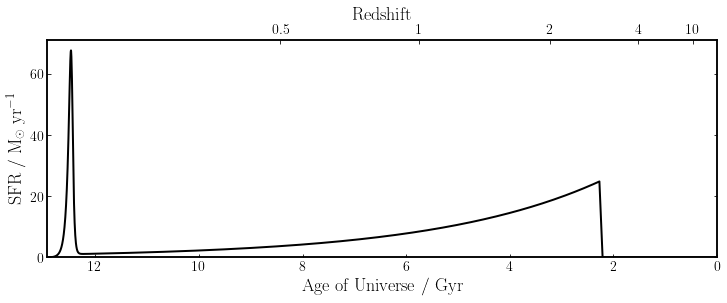

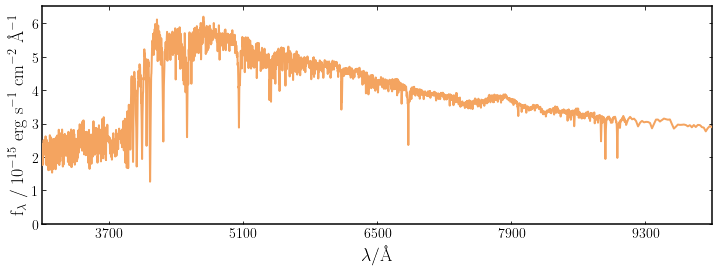

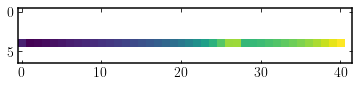

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'delta', 'metallicity': (0.01, 2.5), 'metallicity_prior': 'log_10'}, 'redshift': (0.0392, 0.0408)}


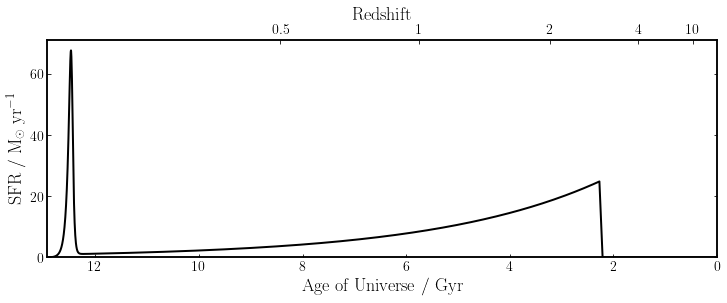

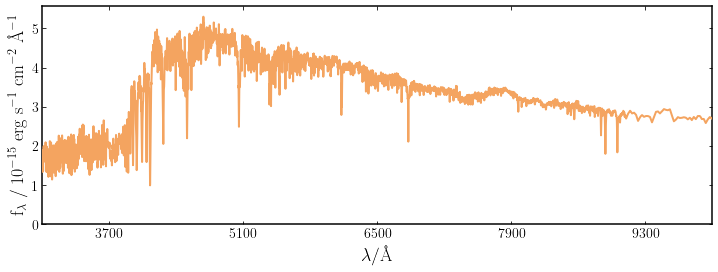

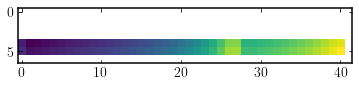

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'delta', 'metallicity': (0.01, 2.5), 'metallicity_prior': 'log_10'}, 'redshift': (0.0392, 0.0408)}


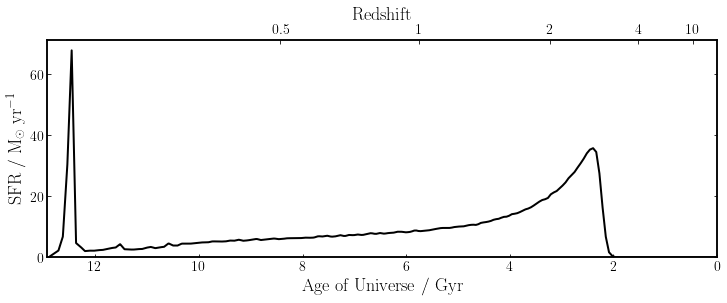

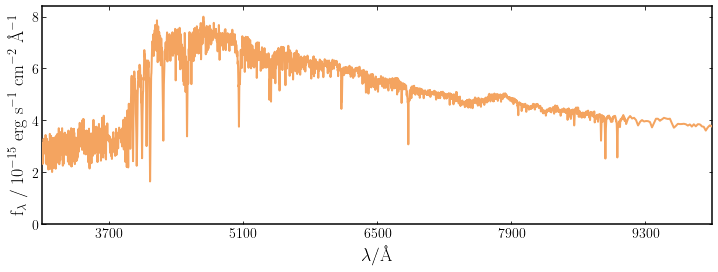

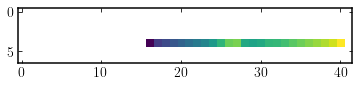

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'delta', 'metallicity': (0.01, 2.5), 'metallicity_prior': 'log_10'}, 'redshift': (0.0392, 0.0408)}


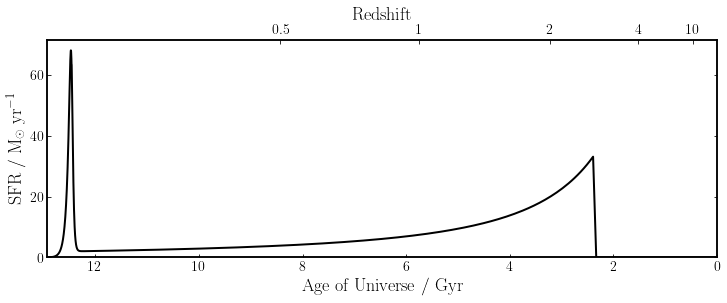

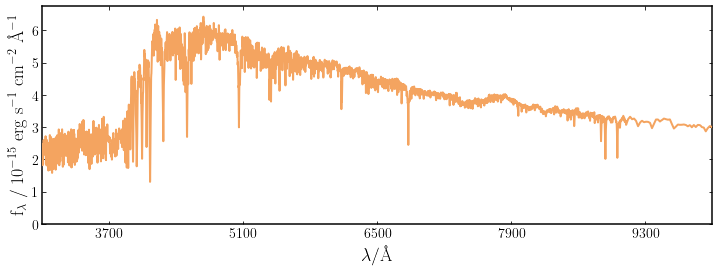

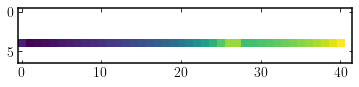

{'psb_twin': {'age': (4, 14.0), 'alpha1': (0.01, 5), 'alpha1_prior': 'log_10', 'beta1': 75236.0609, 'massformed': (6, 13), 'burstage': (0, 2), 'alpha2': (0.01, 1000), 'alpha2_prior': 'log_10', 'beta2': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10'}, 'redshift': (0.0392, 0.0408)}


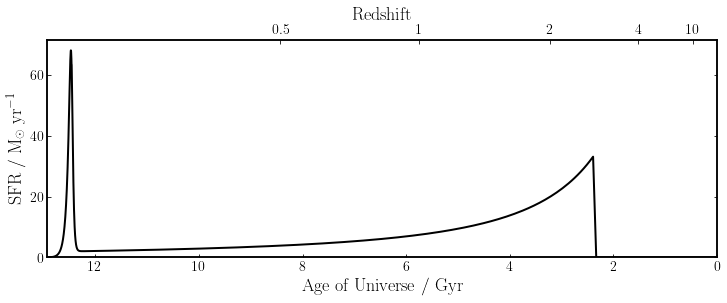

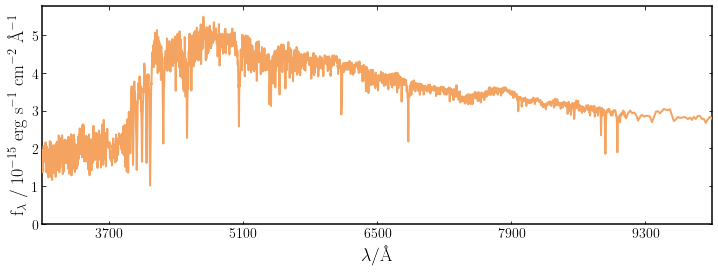

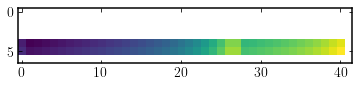

{'psb_twin': {'age': (4, 14.0), 'alpha1': (0.01, 5), 'alpha1_prior': 'log_10', 'beta1': 75236.0609, 'massformed': (6, 13), 'burstage': (0, 2), 'alpha2': (0.01, 1000), 'alpha2_prior': 'log_10', 'beta2': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10'}, 'redshift': (0.0392, 0.0408)}


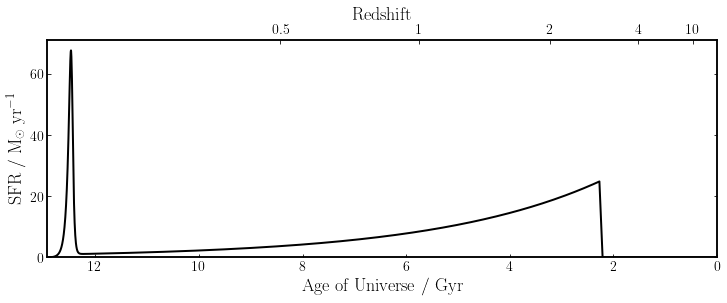

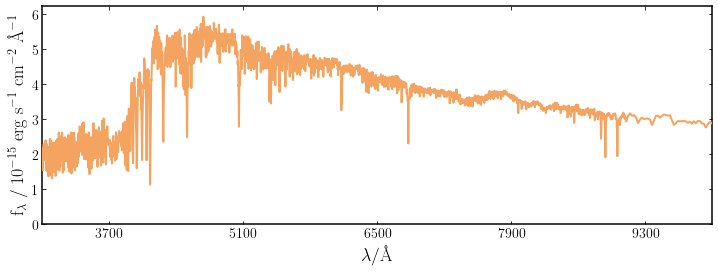

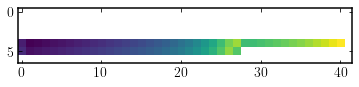

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': 1.0, 'metallicity_burst': 2.0}, 'redshift': (0.0392, 0.0408)}


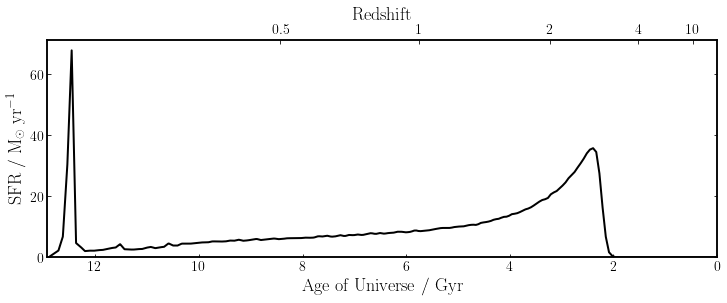

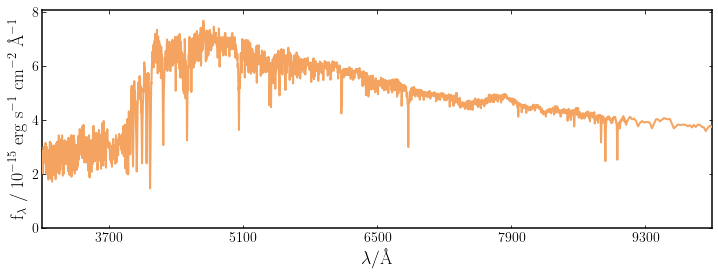

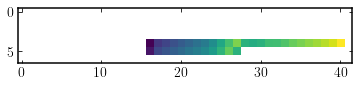

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': 1.0, 'metallicity_burst': 2.0}, 'redshift': (0.0392, 0.0408)}


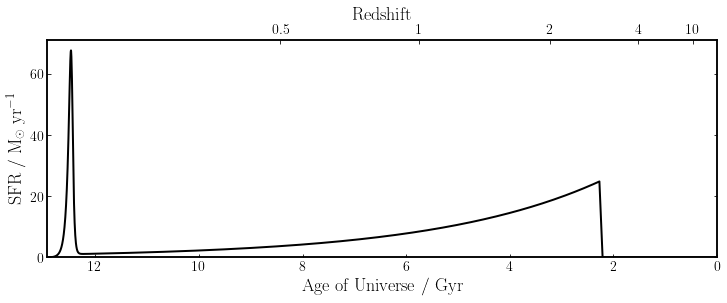

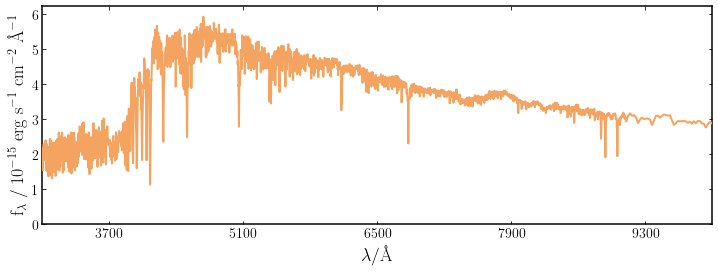

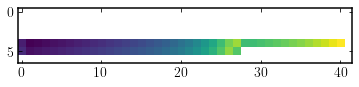

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10'}, 'redshift': (0.0392, 0.0408)}


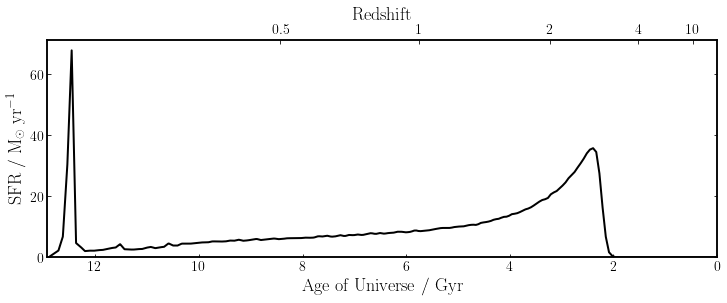

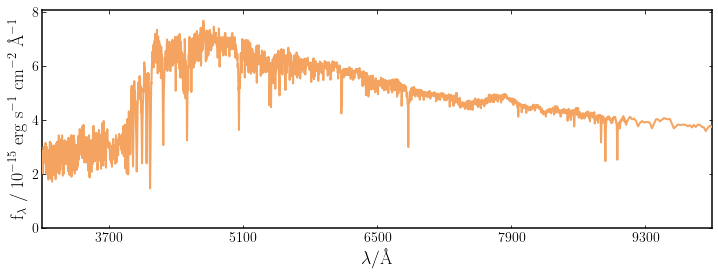

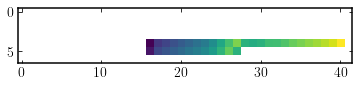

{'psb_twin': {'age': (4, 14.0), 'alpha1': (0.01, 5), 'alpha1_prior': 'log_10', 'beta1': 75236.0609, 'massformed': (6, 13), 'burstage': (0, 2), 'alpha2': (0.01, 1000), 'alpha2_prior': 'log_10', 'beta2': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10'}, 'redshift': (0.0392, 0.0408)}


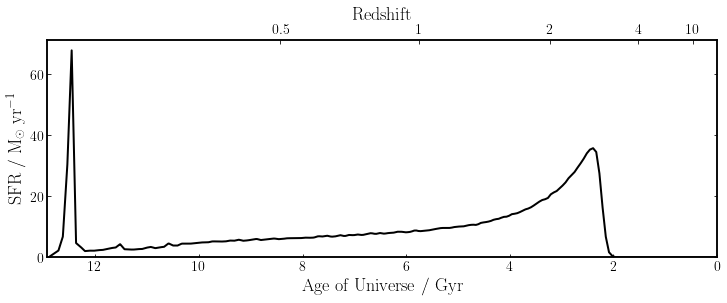

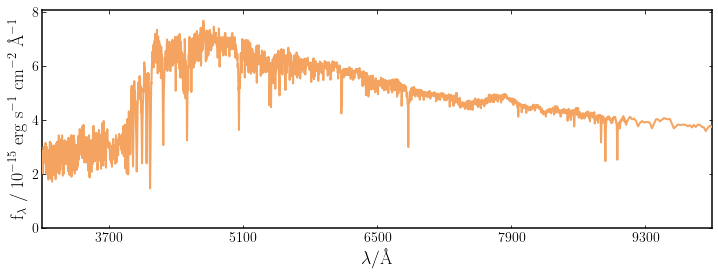

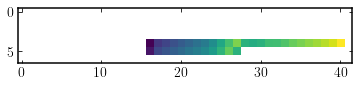

{'psb_twin': {'age': (4, 14.0), 'alpha1': (0.01, 5), 'alpha1_prior': 'log_10', 'beta1': 75236.0609, 'massformed': (6, 13), 'burstage': (0, 2), 'alpha2': (0.01, 1000), 'alpha2_prior': 'log_10', 'beta2': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10'}, 'redshift': (0.0392, 0.0408)}


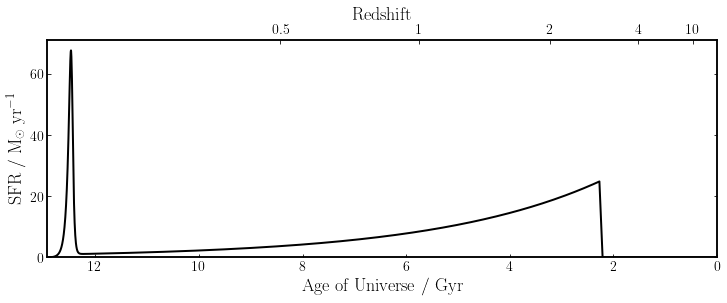

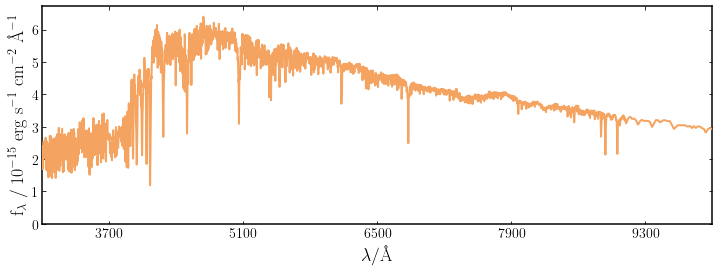

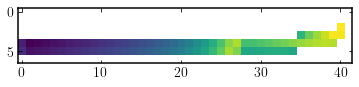

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_linear_step', 'metallicity_scatter': 'delta', 'metallicity_burst': 2.0, 'metallicity_slope': -0.1, 'metallicity_zero': 1.2924069744375968}, 'redshift': (0.0392, 0.0408)}


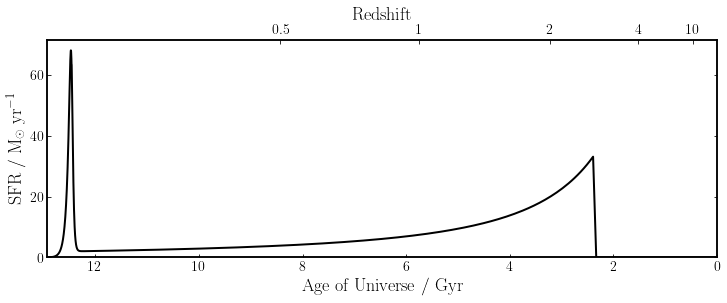

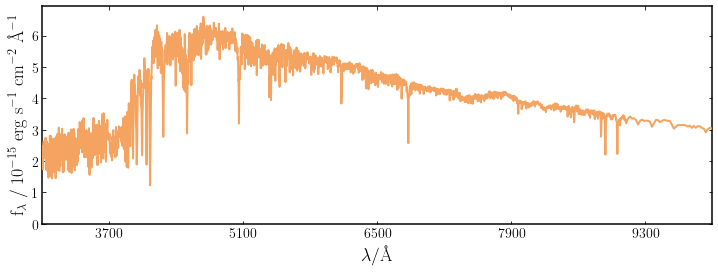

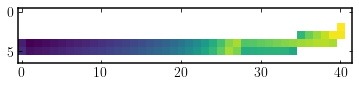

{'psb_twin': {'age': (4, 14.0), 'alpha1': (0.01, 5), 'alpha1_prior': 'log_10', 'beta1': 75236.0609, 'massformed': (6, 13), 'burstage': (0, 2), 'alpha2': (0.01, 1000), 'alpha2_prior': 'log_10', 'beta2': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_linear_step', 'metallicity_scatter': 'delta', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10', 'metallicity_slope': (-0.5, 0.5), 'metallicity_zero': (-0.5, 3.0)}, 'redshift': (0.0392, 0.0408)}


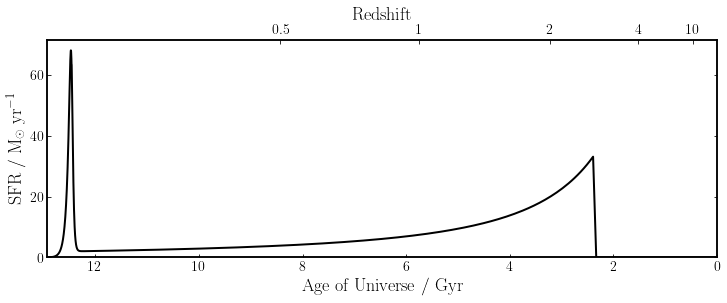

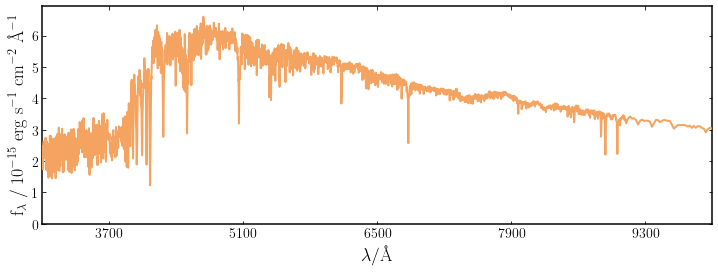

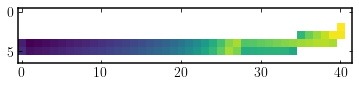

{'psb_twin': {'age': (4, 14.0), 'alpha1': (0.01, 5), 'alpha1_prior': 'log_10', 'beta1': 75236.0609, 'massformed': (6, 13), 'burstage': (0, 2), 'alpha2': (0.01, 1000), 'alpha2_prior': 'log_10', 'beta2': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_linear_step', 'metallicity_scatter': 'delta', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10', 'metallicity_slope': (-0.5, 0.5), 'metallicity_zero': (-0.5, 3.0)}, 'redshift': (0.0392, 0.0408)}


In [11]:
# creating models, setting up fit instructions
models = []
instructions = []
for i,row in fit_table.iterrows():
    models.append(gen_model(row, vb=True))
    fit_instructions = get_fit_instructions(row)
    print(fit_instructions)
    instructions.append(fit_instructions)

In [12]:
# actually fitting
for i,row in fit_table.iterrows():
    print(f'run {i+1} of {len(fit_table.index)}')
    psb_model = models[i]
    fit_instructions = instructions[i]
    fit_obj = fitting('../../..', psb_model, 
                  0.04, 1, sky_masking=False, full=True,
                  model_galaxy_SNR=15)
    
    ID = row['galID']
    runID = row['runID']
    print('runID =', runID)
    
    galaxy = pipes.galaxy(ID, fit_obj.load_manga_spec, photometry_exists=False)
    pipes.config.Rspec = 4340
    fit = pipes.fit(galaxy, fit_instructions, run=runID)
    fit.fit(verbose=False, n_live=row['f_nlive'])

run 1 of 13
runID = psb2_delta_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psb2_delta_nlive400_bin_by_1_4340_Rspec/psb2_uniform1Zsun.h5

Fitting not performed as results have already been loaded from pipes/posterior/psb2_delta_nlive400_bin_by_1_4340_Rspec/psb2_uniform1Zsun.h5. To start over delete this file or change run.

run 2 of 13
runID = psb2_delta_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psb2_delta_nlive400_bin_by_1_4340_Rspec/psb2_uniform2Zsun.h5

Fitting not performed as results have already been loaded from pipes/posterior/psb2_delta_nlive400_bin_by_1_4340_Rspec/psb2_uniform2Zsun.h5. To start over delete this file or change run.

run 3 of 13
runID = psb2_delta_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psb2_delta_nlive400_bin_by_1_4340_Rspec/yirui_uniform1Zsun.h5

Fitting not performed as results have already been loaded from pipes/posterior/psb2_delta_nlive400_bin_by_1_4340_Rspec/yirui_uniform1Zsun.h5. To s

m_SFH                                      psb_wild2020
m_CEH                                             delta
m_zmet_old                                            1
m_zmet_burst                                        NaN
m_zmet_slope                                        NaN
f_SFH                                      psb_wild2020
f_CEH                                             delta
f_CEH_fixed                                       False
f_nlive                                             400
galID                                 psb2_uniform1Zsun
runID           psb2_delta_nlive400_bin_by_1_4340_Rspec
old_fit                                           False
Name: 0, dtype: object
runID = psb2_delta_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psb2_delta_nlive400_bin_by_1_4340_Rspec/psb2_uniform1Zsun.h5



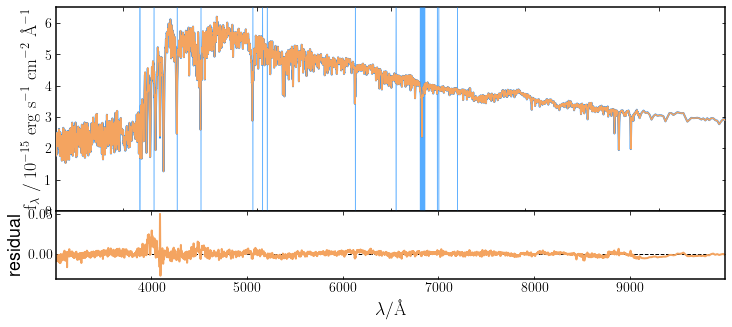

only recovered 0.9705550601438855 of total mass formed.
10.919837132336134 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477390176272133
posterior f_burst and t_burst: [0.08063622 0.08565268 0.09316401] [12.4714913  12.51310993 12.54536588]


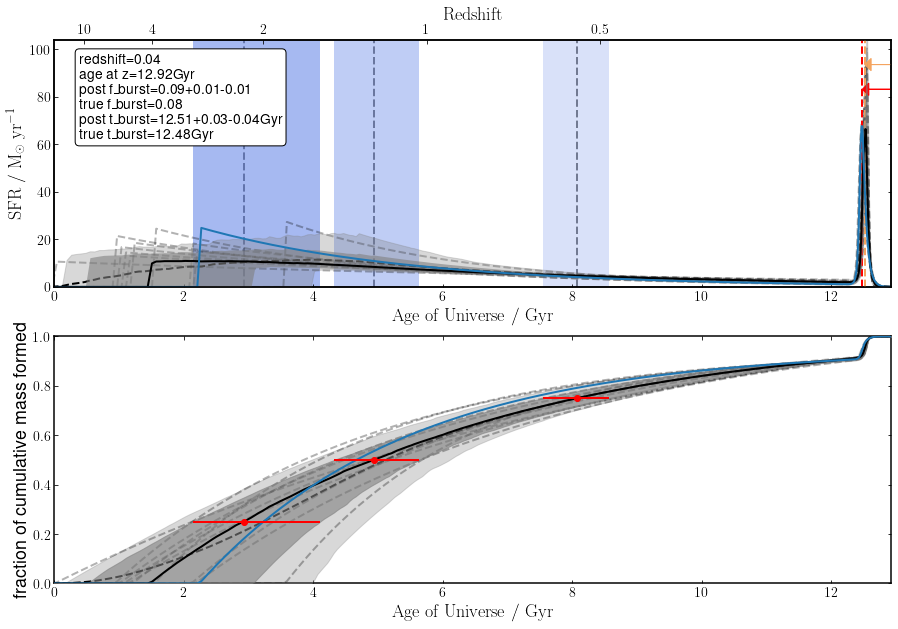

m_SFH                                      psb_wild2020
m_CEH                                             delta
m_zmet_old                                            2
m_zmet_burst                                        NaN
m_zmet_slope                                        NaN
f_SFH                                      psb_wild2020
f_CEH                                             delta
f_CEH_fixed                                       False
f_nlive                                             400
galID                                 psb2_uniform2Zsun
runID           psb2_delta_nlive400_bin_by_1_4340_Rspec
old_fit                                           False
Name: 1, dtype: object
runID = psb2_delta_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psb2_delta_nlive400_bin_by_1_4340_Rspec/psb2_uniform2Zsun.h5



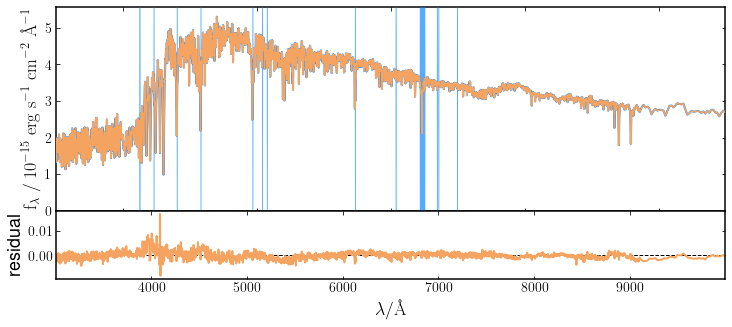

only recovered 0.976684801781772 of total mass formed.
10.922571383841772 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477386530417927
posterior f_burst and t_burst: [0.08024952 0.08769363 0.09733426] [12.44211528 12.48078538 12.51950525]


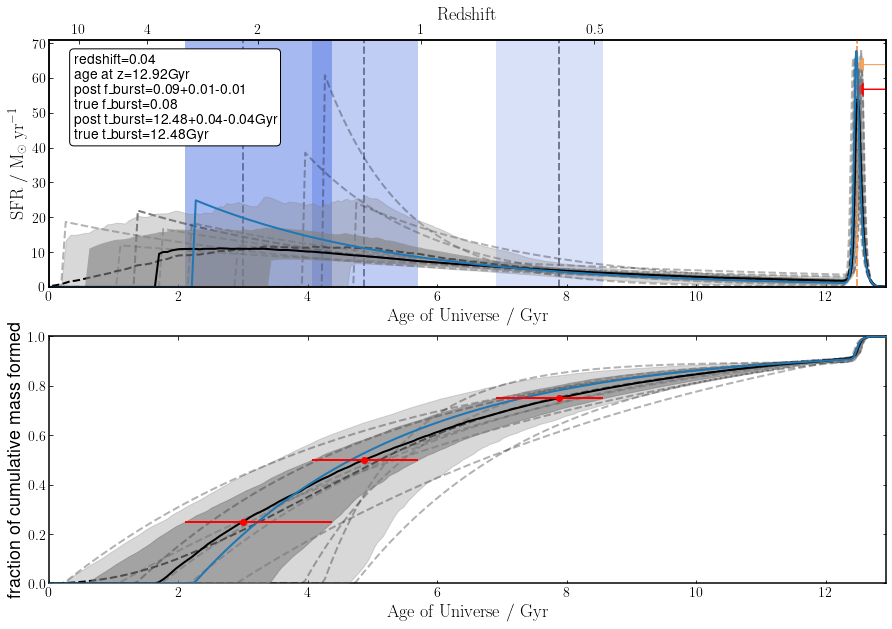

m_SFH                                             yirui
m_CEH                                             delta
m_zmet_old                                            1
m_zmet_burst                                        NaN
m_zmet_slope                                        NaN
f_SFH                                      psb_wild2020
f_CEH                                             delta
f_CEH_fixed                                       False
f_nlive                                             400
galID                                yirui_uniform1Zsun
runID           psb2_delta_nlive400_bin_by_1_4340_Rspec
old_fit                                           False
Name: 2, dtype: object
runID = psb2_delta_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psb2_delta_nlive400_bin_by_1_4340_Rspec/yirui_uniform1Zsun.h5



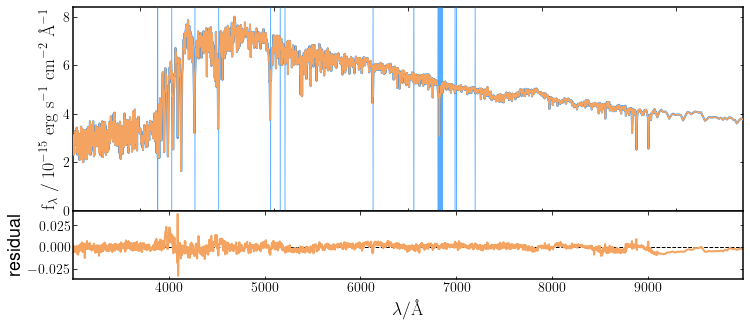

only recovered 0.9734877850311776 of total mass formed.
11.015565346692668 11.027234840170811
model f_burst and t_burst: 0.08865578690294339 12.441382878560388
posterior f_burst and t_burst: [0.07644744 0.08256271 0.08859537] [12.45956376 12.48380918 12.51786037]


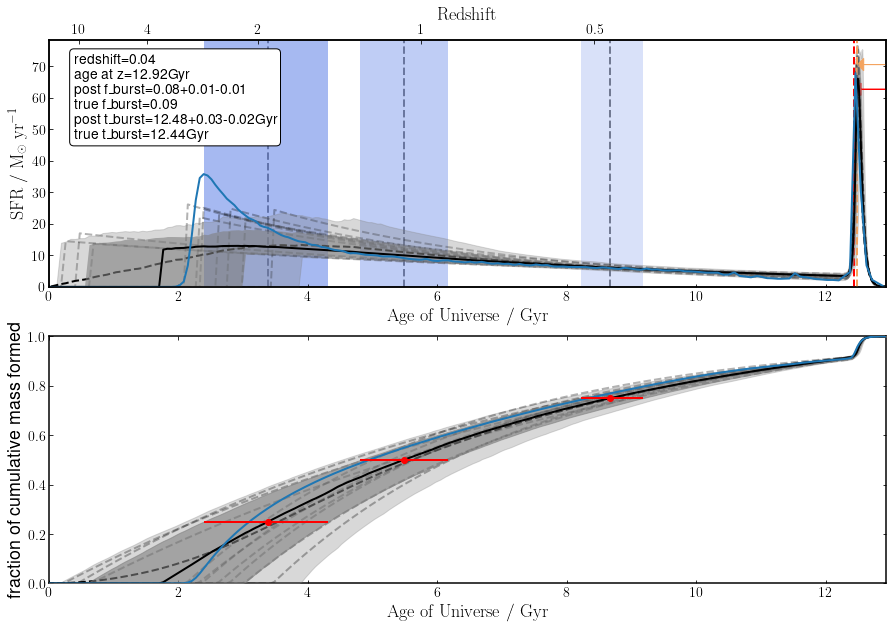

m_SFH                                             psb_twin
m_CEH                                                delta
m_zmet_old                                               1
m_zmet_burst                                           NaN
m_zmet_slope                                           NaN
f_SFH                                             psb_twin
f_CEH                                                2step
f_CEH_fixed                                          False
f_nlive                                                400
galID                                 psbtwin_uniform1Zsun
runID           psbtwin_2step_nlive400_bin_by_1_4340_Rspec
old_fit                                               True
Name: 3, dtype: object
runID = psbtwin_2step_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psbtwin_2step_nlive400_bin_by_1_4340_Rspec/psbtwin_uniform1Zsun.h5



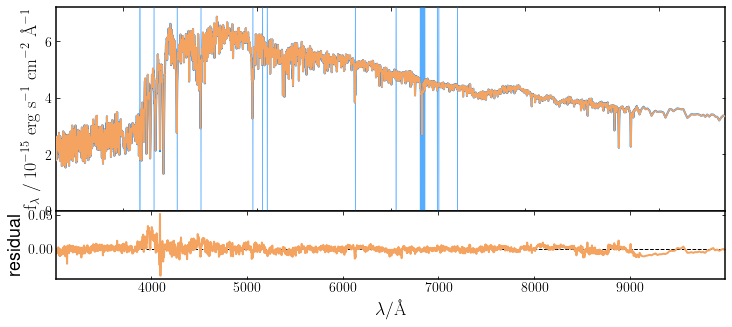

only recovered 0.9086529594831565 of total mass formed.
10.985631076456468 11.027233031033742
model f_burst and t_burst: 0.08581708823110837 12.37056313943205
posterior f_burst and t_burst: [0.07993286 0.09132348 0.10252041] [12.40377366 12.45303058 12.51885588]


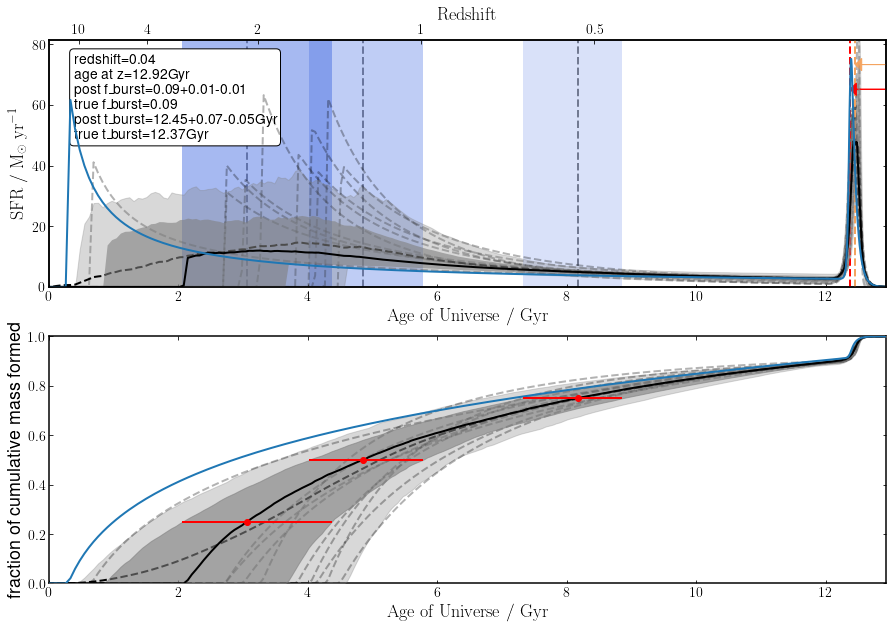

m_SFH                                             psb_twin
m_CEH                                                delta
m_zmet_old                                               2
m_zmet_burst                                           NaN
m_zmet_slope                                           NaN
f_SFH                                             psb_twin
f_CEH                                                2step
f_CEH_fixed                                          False
f_nlive                                                400
galID                                 psbtwin_uniform2Zsun
runID           psbtwin_2step_nlive400_bin_by_1_4340_Rspec
old_fit                                               True
Name: 4, dtype: object
runID = psbtwin_2step_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psbtwin_2step_nlive400_bin_by_1_4340_Rspec/psbtwin_uniform2Zsun.h5



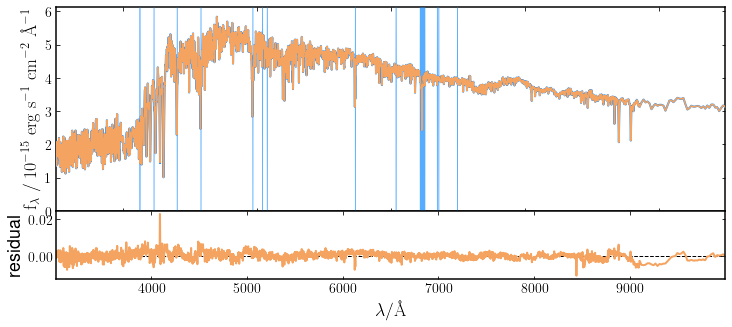

only recovered 0.9075296371283924 of total mass formed.
10.985093847696328 11.027233031033742
model f_burst and t_burst: 0.08581708823110837 12.370561247058202
posterior f_burst and t_burst: [0.08365365 0.09552431 0.108047  ] [12.36926835 12.41519831 12.46647616]


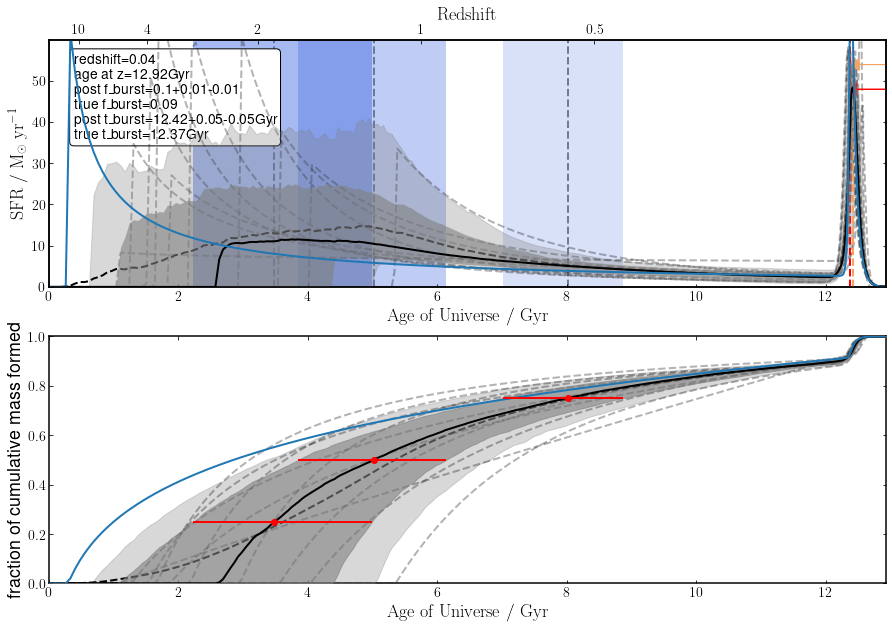

m_SFH                                            psb_wild2020
m_CEH                                                   2step
m_zmet_old                                                  1
m_zmet_burst                                                2
m_zmet_slope                                              NaN
f_SFH                                            psb_wild2020
f_CEH                                                   2step
f_CEH_fixed                                              True
f_nlive                                                   400
galID                                              psb2_2step
runID           psb2_2step_fixed_nlive400_bin_by_1_4340_Rspec
old_fit                                                 False
Name: 5, dtype: object
runID = psb2_2step_fixed_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psb2_2step_fixed_nlive400_bin_by_1_4340_Rspec/psb2_2step.h5



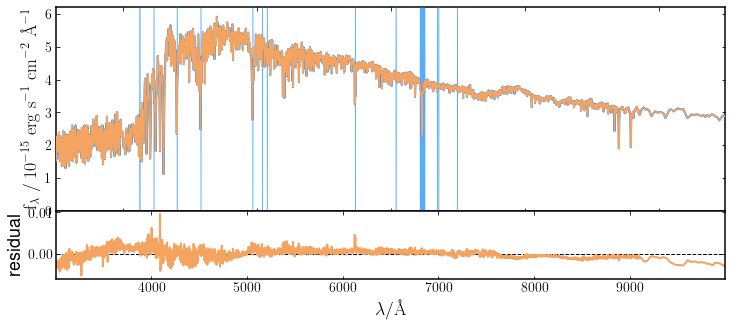

only recovered 0.9944535539133277 of total mass formed.
10.930401458290486 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477380219143306
posterior f_burst and t_burst: [0.0822875 0.0884203 0.0967289] [12.44704931 12.47383323 12.49523412]


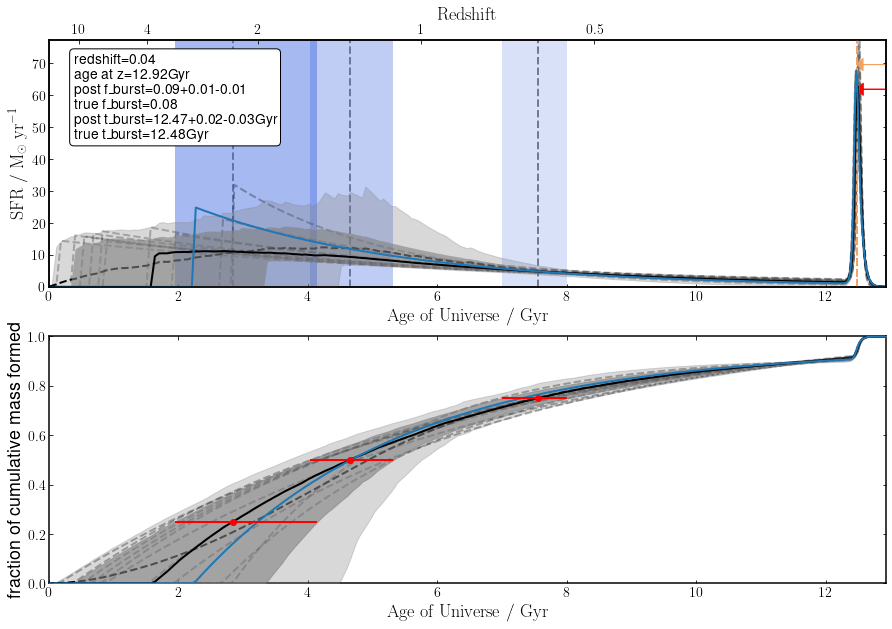

m_SFH                                                   yirui
m_CEH                                                   2step
m_zmet_old                                                  1
m_zmet_burst                                                2
m_zmet_slope                                              NaN
f_SFH                                            psb_wild2020
f_CEH                                                   2step
f_CEH_fixed                                              True
f_nlive                                                   400
galID                                             yirui_2step
runID           psb2_2step_fixed_nlive400_bin_by_1_4340_Rspec
old_fit                                                 False
Name: 6, dtype: object
runID = psb2_2step_fixed_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psb2_2step_fixed_nlive400_bin_by_1_4340_Rspec/yirui_2step.h5



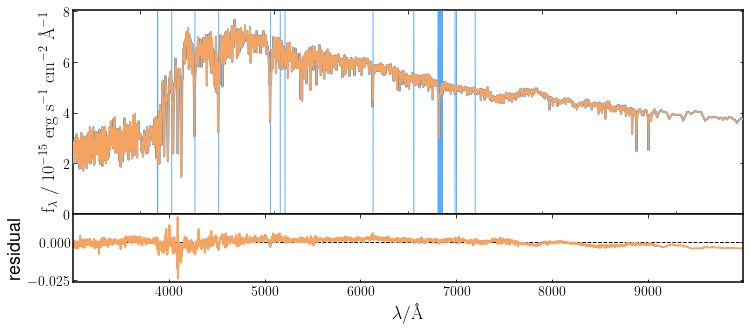

only recovered 0.9973701165637867 of total mass formed.
11.026091191815464 11.027234840170811
model f_burst and t_burst: 0.08865578690294339 12.441385154694787
posterior f_burst and t_burst: [0.07535433 0.08042816 0.08652786] [12.46044476 12.48561908 12.50239293]


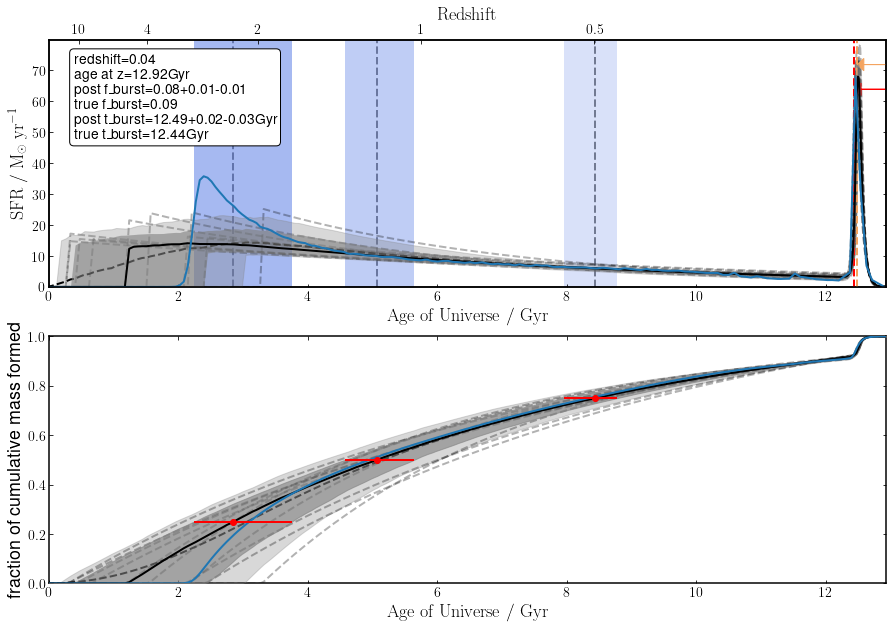

m_SFH                                      psb_wild2020
m_CEH                                             2step
m_zmet_old                                            1
m_zmet_burst                                          2
m_zmet_slope                                        NaN
f_SFH                                      psb_wild2020
f_CEH                                             2step
f_CEH_fixed                                       False
f_nlive                                             400
galID                                        psb2_2step
runID           psb2_2step_nlive400_bin_by_1_4340_Rspec
old_fit                                           False
Name: 7, dtype: object
runID = psb2_2step_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psb2_2step_nlive400_bin_by_1_4340_Rspec/psb2_2step.h5



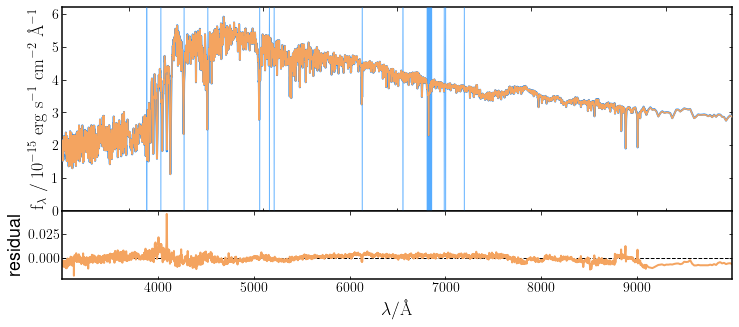

only recovered 0.9547184896546029 of total mass formed.
10.912692287593874 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477387635645405
posterior f_burst and t_burst: [0.07963471 0.08573583 0.09279238] [12.46394065 12.5072742  12.53179616]


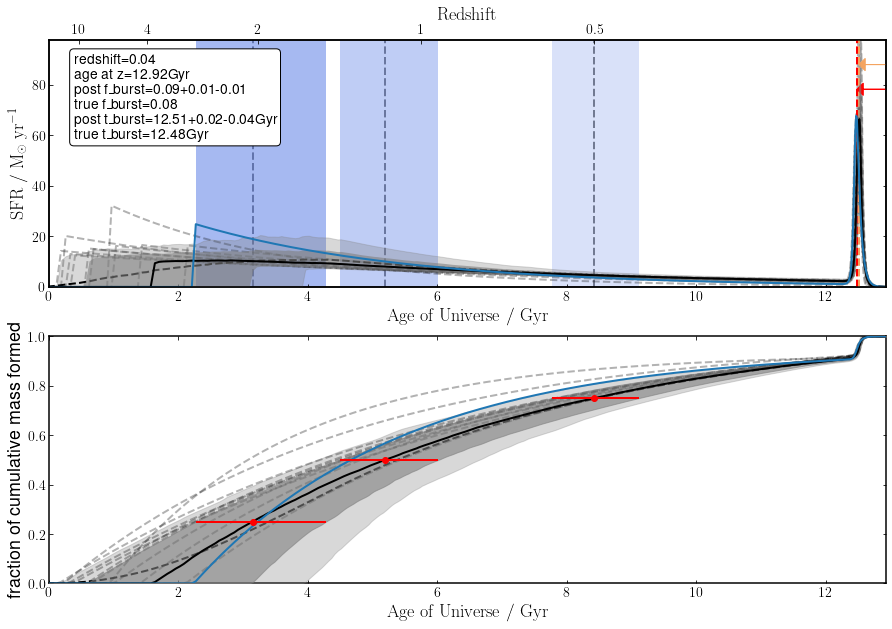

m_SFH                                                yirui
m_CEH                                                2step
m_zmet_old                                               1
m_zmet_burst                                             2
m_zmet_slope                                           NaN
f_SFH                                             psb_twin
f_CEH                                                2step
f_CEH_fixed                                          False
f_nlive                                                400
galID                                          yirui_2step
runID           psbtwin_2step_nlive400_bin_by_1_4340_Rspec
old_fit                                              False
Name: 8, dtype: object
runID = psbtwin_2step_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psbtwin_2step_nlive400_bin_by_1_4340_Rspec/yirui_2step.h5



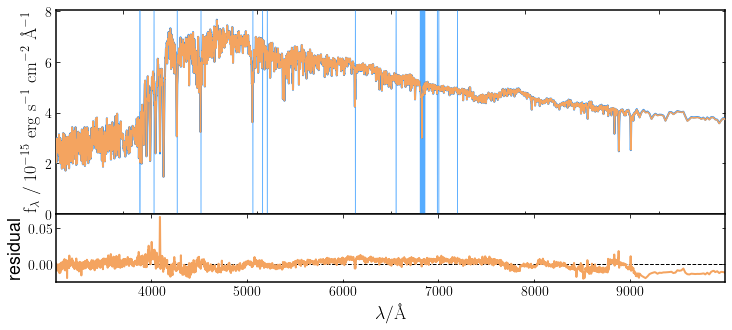

only recovered 0.915659898755027 of total mass formed.
10.988969034885317 11.027234840170811
model f_burst and t_burst: 0.089153644419279 12.441258553255215
posterior f_burst and t_burst: [0.06525017 0.07636845 0.08766086] [12.47116621 12.50996167 12.55551339]


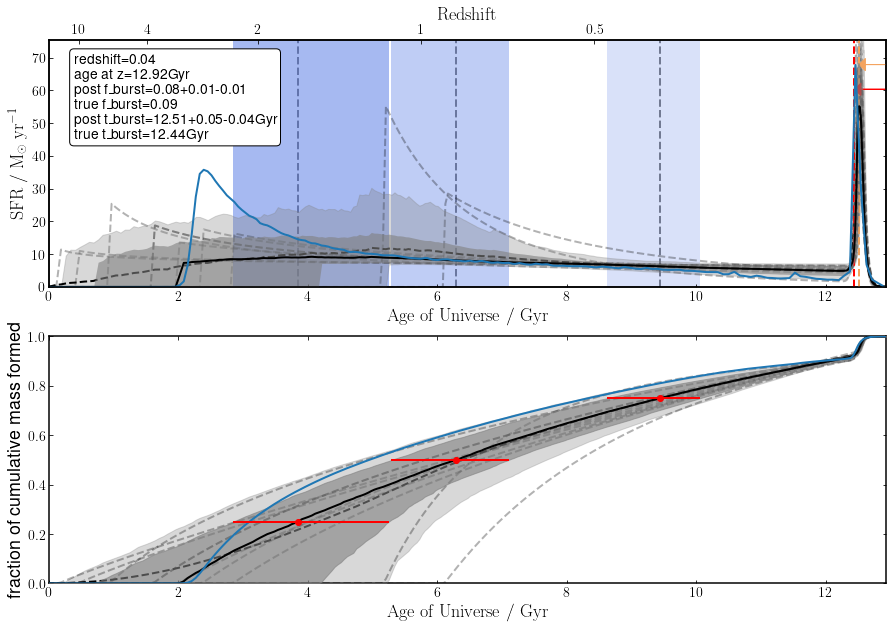

m_SFH                                                 yirui
m_CEH                                                 2step
m_zmet_old                                                1
m_zmet_burst                                              2
m_zmet_slope                                            NaN
f_SFH                                              psb_twin
f_CEH                                                 2step
f_CEH_fixed                                           False
f_nlive                                                1000
galID                                           yirui_2step
runID           psbtwin_2step_nlive1000_bin_by_1_4340_Rspec
old_fit                                               False
Name: 9, dtype: object
runID = psbtwin_2step_nlive1000_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psbtwin_2step_nlive1000_bin_by_1_4340_Rspec/yirui_2step.h5



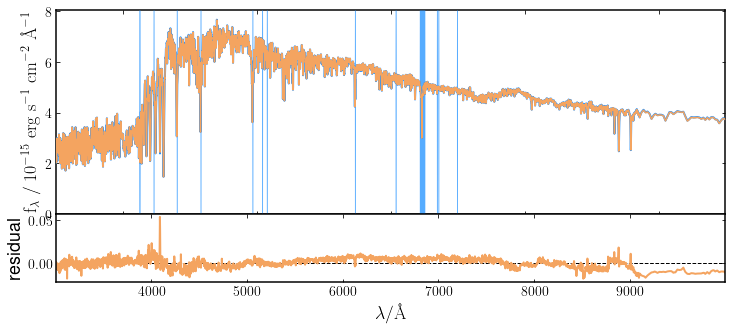

only recovered 0.9287982883777807 of total mass formed.
10.99515624656889 11.027234840170811
model f_burst and t_burst: 0.089153644419279 12.441256654739464
posterior f_burst and t_burst: [0.06677301 0.07754017 0.09018276] [12.4560241  12.49982348 12.54812846]


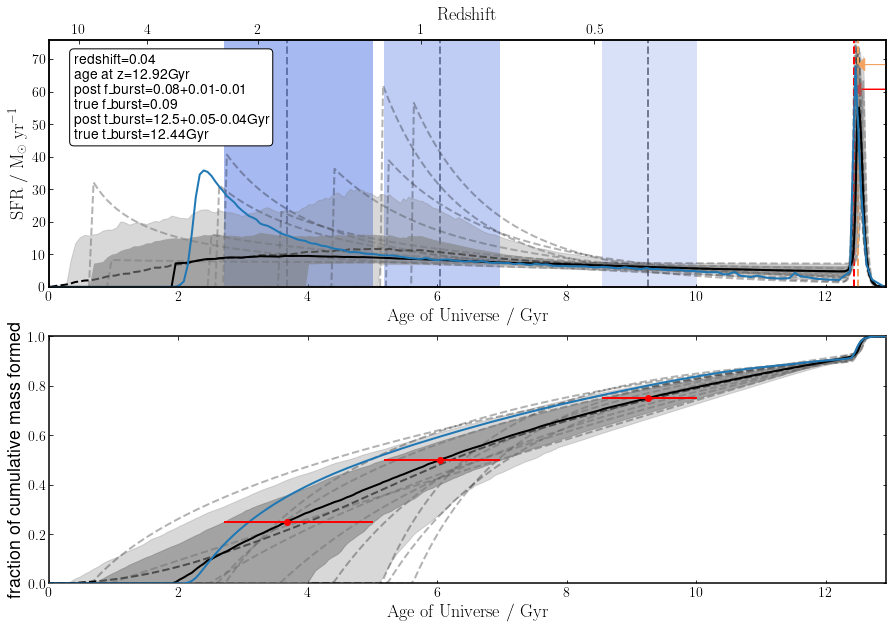

m_SFH                                                psb_wild2020
m_CEH                                                 slope+2step
m_zmet_old                                                   auto
m_zmet_burst                                                    2
m_zmet_slope                                                 -0.1
f_SFH                                                psb_wild2020
f_CEH                                                 slope+2step
f_CEH_fixed                                                  True
f_nlive                                                       400
galID                                            psb2_slope+2step
runID           psb2_slope+2step_fixed_nlive400_bin_by_1_4340_...
old_fit                                                     False
Name: 10, dtype: object
runID = psb2_slope+2step_fixed_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psb2_slope+2step_fixed_nlive400_bin_by_1_4340_Rspec/psb2_slope+2step.h5



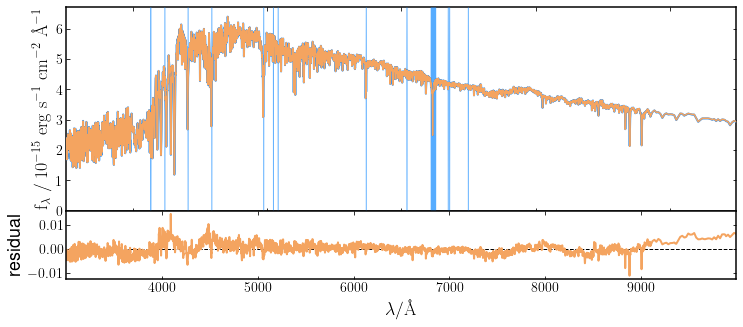

only recovered 0.9653593025108523 of total mass formed.
10.917505940077978 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477384413533597
posterior f_burst and t_burst: [0.08402647 0.08984163 0.09641499] [12.44523475 12.47339951 12.50546817]


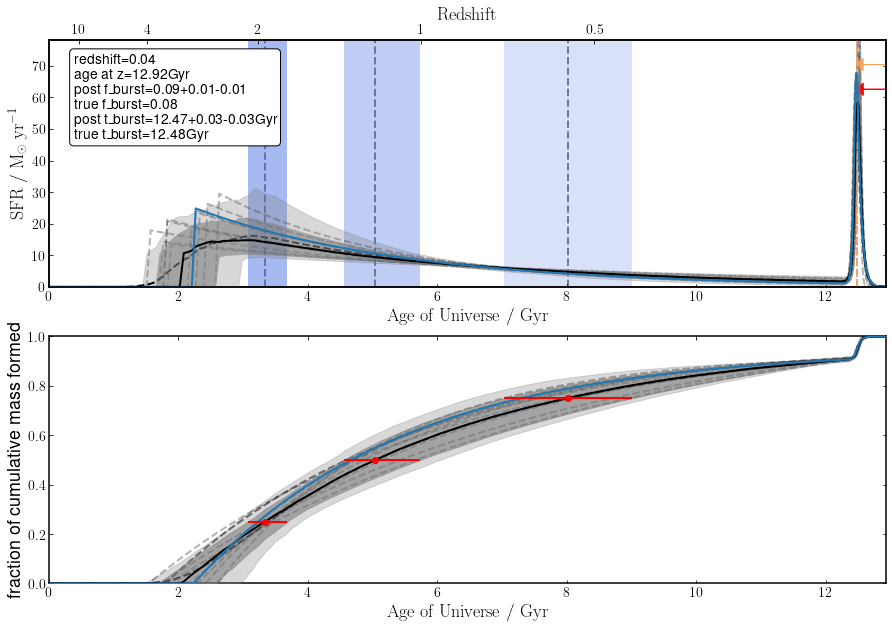

m_SFH                                                   psb_twin
m_CEH                                                slope+2step
m_zmet_old                                                  auto
m_zmet_burst                                                   2
m_zmet_slope                                                -0.1
f_SFH                                                   psb_twin
f_CEH                                                slope+2step
f_CEH_fixed                                                False
f_nlive                                                      400
galID                                        psbtwin_slope+2step
runID           psbtwin_slope+2step_nlive400_bin_by_1_4340_Rspec
old_fit                                                     True
Name: 11, dtype: object
runID = psbtwin_slope+2step_nlive400_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psbtwin_slope+2step_nlive400_bin_by_1_4340_Rspec/psbtwin_slope+2step.h5



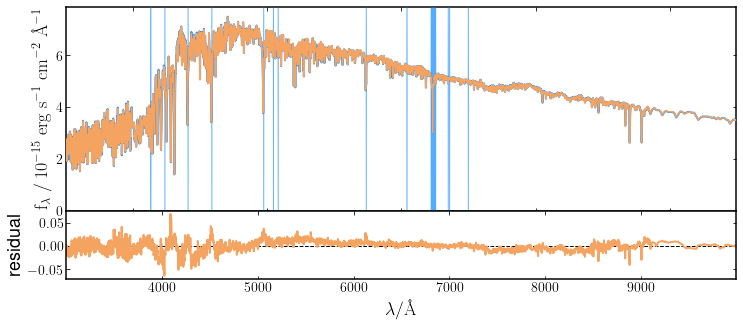

only recovered 0.760690071194524 of total mass formed.
10.90844077875508 11.027233031033742
model f_burst and t_burst: 0.08581708823110837 12.370555836249038
posterior f_burst and t_burst: [0.05874609 0.06670975 0.07792232] [12.43887061 12.47673308 12.50318091]


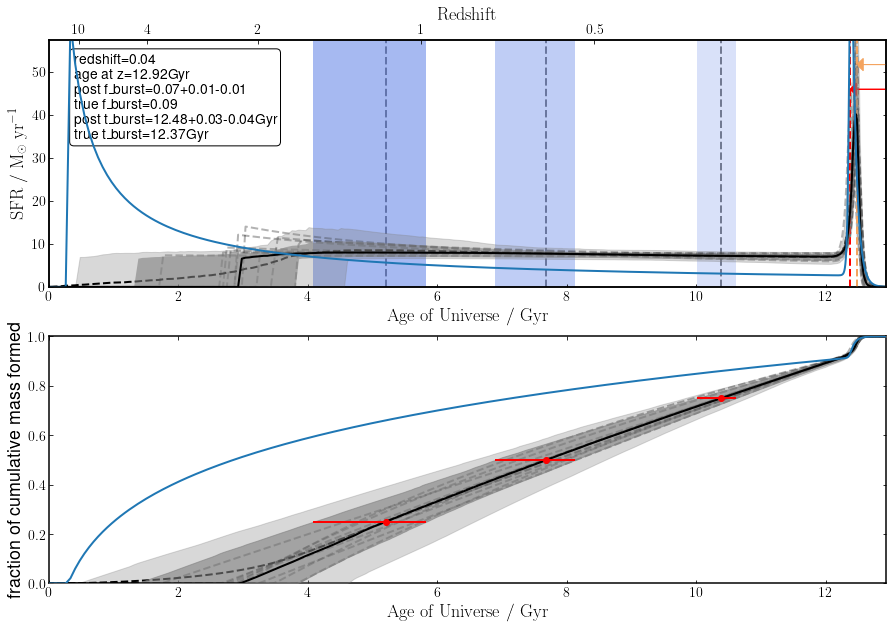

m_SFH                                                    psb_twin
m_CEH                                                 slope+2step
m_zmet_old                                                   auto
m_zmet_burst                                                    2
m_zmet_slope                                                 -0.1
f_SFH                                                    psb_twin
f_CEH                                                 slope+2step
f_CEH_fixed                                                 False
f_nlive                                                      1000
galID                                         psbtwin_slope+2step
runID           psbtwin_slope+2step_nlive1000_bin_by_1_4340_Rspec
old_fit                                                      True
Name: 12, dtype: object
runID = psbtwin_slope+2step_nlive1000_bin_by_1_4340_Rspec

Results loaded from pipes/posterior/psbtwin_slope+2step_nlive1000_bin_by_1_4340_Rspec/psbtwin_slope+2step.h5



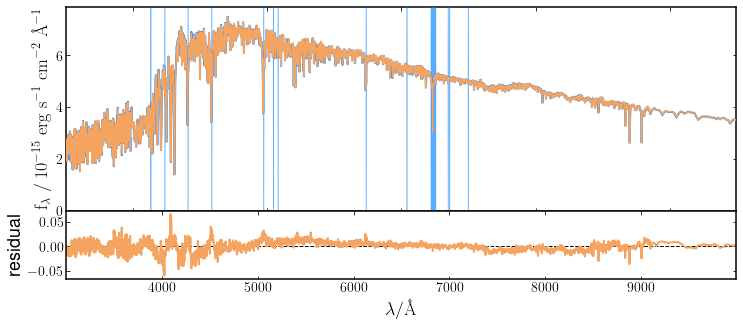

only recovered 0.7694357958548181 of total mass formed.
10.913405417814262 11.027233031033742
model f_burst and t_burst: 0.08581708823110837 12.370555127357942
posterior f_burst and t_burst: [0.059971   0.06948766 0.08587323] [12.41564533 12.46954736 12.50422695]


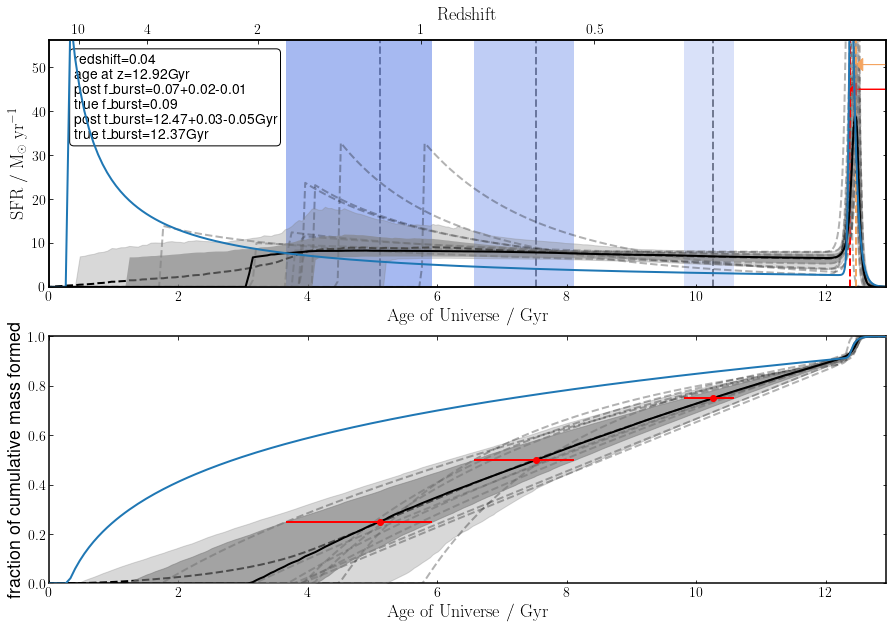

In [16]:
pipes.plotting.latex_names["metallicity_slope"] = "\\mathrm{Z_{slope}}"
pipes.plotting.latex_units["metallicity_slope"] = "Z_{\\odot}\\ Gyr^{-1}"
pipes.plotting.latex_names["metallicity_zero"] = "\\mathrm{Z_{0}}"
pipes.plotting.latex_units["metallicity_zero"] = "Z_{\\odot}"

import os
for i,row in fit_table.iterrows():
    if row['old_fit']:
        # all old_fits are only using psb_twin for model creation
        psb_twin_popt = [1.26348321e+01, 8.70221355e-01, 9.64793965e+03, 5.53510051e-01, 
                         1.83730405e+02, 6.79456054e+02, 8.64240632e-02, 1.10272314e+01]
        psb_model = gen_model(row, vb=False, old_fit_params=psb_twin_popt)
    else:
        psb_model = models[i]
    fit_obj = fitting('../../..', psb_model, 
                  0.04, 1, sky_masking=False, full=True,
                  model_galaxy_SNR=15)
    
    ID = row['galID']
    runID = row['runID']
    print(row)
    print('runID =', runID)
    
    galaxy = pipes.galaxy(ID, fit_obj.load_manga_spec, photometry_exists=False)
    pipes.config.Rspec = 4340
    fit = pipes.fit(galaxy, {}, run=runID)
    
    #if f'{ID}_fit.pdf' not in os.listdir(f'pipes/plots/{runID}'):
    plot_spec(fit, ID, runID)
    if f'{ID}_corner.pdf' not in os.listdir(f'pipes/plots/{runID}'):
        fig = fit.plot_corner(save=True, show=True)
    plot_sfh(fit, psb_model.sfh.ages*10**-9, psb_model.sfh.sfh,
             ID, runID, samples=10, plot_mean=True, ninty_region=True)

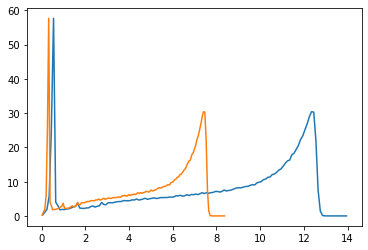

10.350524938318015 Gyr
[7.74881991e+00 3.09874719e+00 3.29999995e-01 3.25136272e+02
 8.04485163e+02 8.68310928e-02 1.08022761e+01]
[7.61891053e+00 3.13893950e+00 3.86650020e+04 3.29999991e-01
 3.24692580e+02 8.11637879e+02 8.73856654e-02 1.07985044e+01]


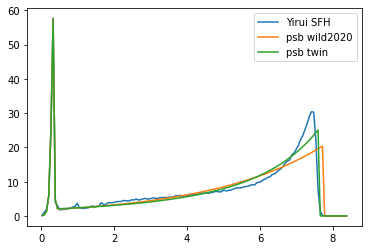

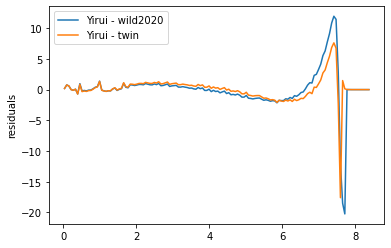

In [9]:
squishing_factor = 0.6
model_ages1 = model_ages_original*squishing_factor
plt.plot(model_ages_original, model_sfh)
plt.plot(model_ages1, model_sfh)
plt.show()
print(cosmo.age(0.04) - cosmo.age(2.5))

# using scipy curve fit to get a fit to the true SFH
popt_wild2020,pcov = scipy.optimize.curve_fit(psb_wild2020, model_ages1, model_sfh, 
                                     bounds=([7,0.5,0,100,100,0,10],[8,10,2,1000,1000,1,12]))
# best fits
print(popt_wild2020)

# using scipy curve fit to get a fit to the true SFH
popt1_twin,pcov = scipy.optimize.curve_fit(psb_twin_, model_ages1, model_sfh, 
                                     bounds=([7,0.01,1000,0,100,100,0,10],[8,1000,100000,2,1000,1000,1,12]))
# best fits
print(popt1_twin)

predict1_sfh_wild2020 = psb_wild2020(model_ages1, *popt_wild2020)
predict1_sfh_twin = psb_twin_(model_ages1, *popt1_twin)
plt.plot(model_ages1, model_sfh, label='Yirui SFH')
plt.plot(model_ages1, predict1_sfh_wild2020, label='psb wild2020')
plt.plot(model_ages1, predict1_sfh_twin, label='psb twin')
plt.legend()
plt.show()
plt.plot(model_ages1, model_sfh-predict1_sfh_wild2020, label='Yirui - wild2020')
plt.plot(model_ages1, model_sfh-predict1_sfh_twin, label='Yirui - twin')
plt.ylabel('residuals')
plt.legend()
plt.show()

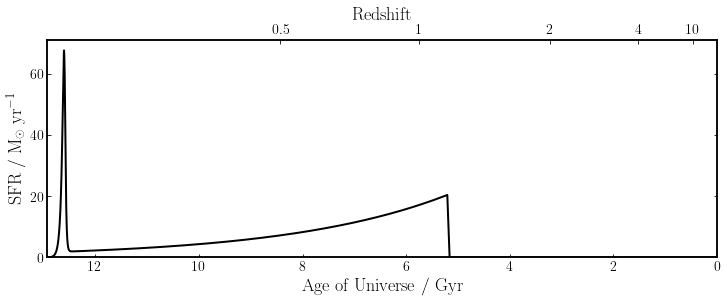

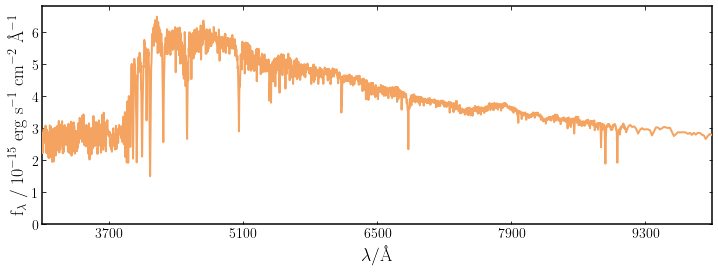

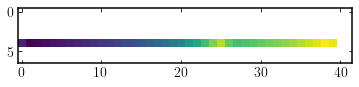

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'delta', 'metallicity': 1.0}, 'redshift': (0.0392, 0.0408)}


In [10]:
test_fit_settings = {'m_SFH':'psb_wild2020', 'm_CEH':'delta',
                 'm_zmet_old':1.0, 'f_SFH':'psb_wild2020',
                 'f_CEH':'delta', 'f_CEH_fixed':True,
                 'f_nlive':400}

galID, runID = genIDs(test_fit_settings)

# creating models, setting up fit instructions
psb_model = gen_model(test_fit_settings, vb=True)
fit_instructions = get_fit_instructions(test_fit_settings)
print(fit_instructions)

runID = psb2_delta_fixed_nlive400_bin_by_1_4340_Rspec


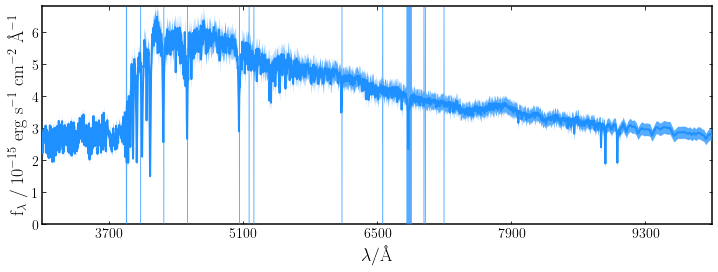


Bagpipes: fitting object psb2_uniform1Zsun


Completed in 502.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_wild2020:age               8.745     10.064     11.080
psb_wild2020:alpha           324.407    443.503    748.600
psb_wild2020:burstage          0.272      0.292      0.320
psb_wild2020:fburst            0.070      0.075      0.081
psb_wild2020:massformed       10.805     10.823     10.840
psb_wild2020:tau               4.531      7.056      9.094
redshift                       0.040      0.040      0.040




In [11]:
fit_obj = fitting('../../..', psb_model, 
              0.04, 1, sky_masking=False, full=True,
              model_galaxy_SNR=15)

ID = galID
print('runID =', runID)

galaxy = pipes.galaxy(ID, fit_obj.load_manga_spec, photometry_exists=False)
galaxy.plot()
pipes.config.Rspec = 4340
fit = pipes.fit(galaxy, fit_instructions, run=runID)
fit.fit(verbose=False)

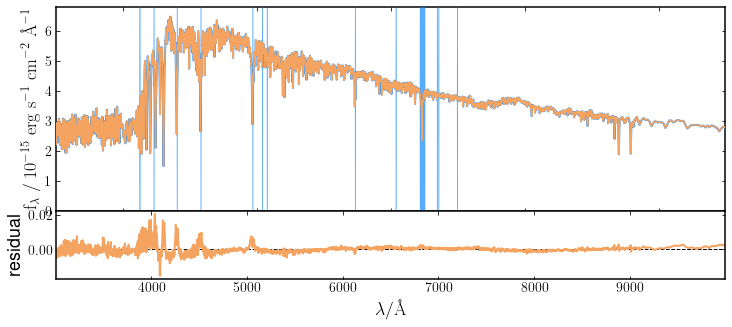

only recovered 1.047665240846066 of total mass formed.
10.822500232148741 10.802277696903742
model f_burst and t_burst: 0.08867351900403024 12.593869165872745
posterior f_burst and t_burst: [0.06993607 0.07477529 0.08088287] [12.60475409 12.6318921  12.65348573]


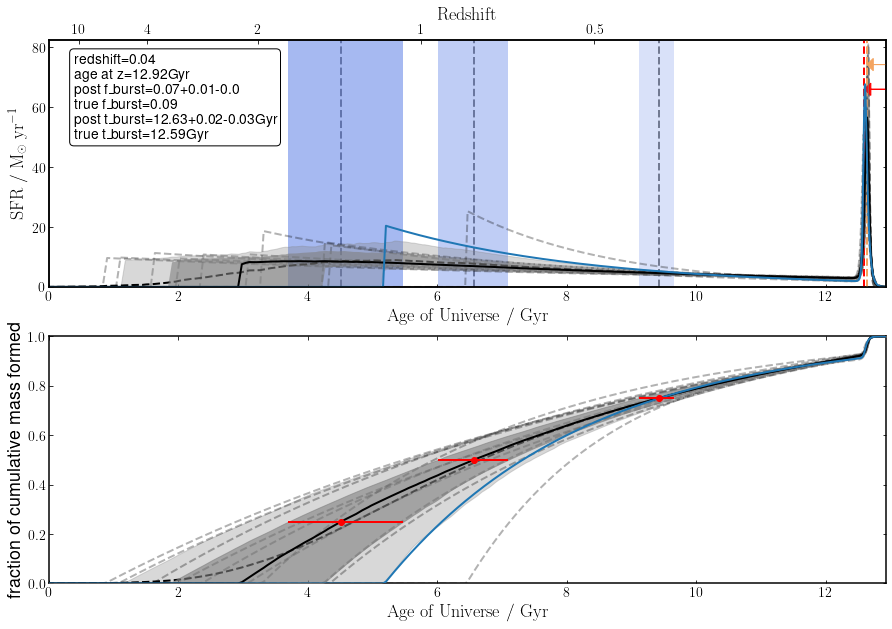

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [12]:
plot_spec(fit, ID, runID)
fig = fit.plot_corner(save=True, show=True)
plot_sfh(fit, psb_model.sfh.ages*10**-9, psb_model.sfh.sfh,
         ID, runID, samples=10, plot_mean=True, ninty_region=True)